# Tracking centroids in succesive layers of k-means (hostility)

In [1]:

import pandas as pd
import copy
from sklearn import preprocessing
import numpy as np
from sklearn.cluster import KMeans
from Normal_dataset_generator import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from TrackingCentroidsMovement import *



In [2]:
import os
os.chdir("..")
root_path = os.getcwd()

Hacemos un minicambio en el algoritmo de la hostilidad para incluir como output los centroides en cada una de las capas. Esta versión se llama hostility_measure_Centroids().

Además, creamos una función llamada plot_hierarchical_quivers_with_complexity() (por ahora solo para 2D) que pinta cómo se van moviendo los centroides en las sucesivas capas y cómo va cambiando su hostilidad. Es un gráfico tipo mapa vectorial con tantos plots como número de capas -1 puesto que va mostrando la transición entre ellos. Las flechas están coloreadas mediante un degradado en función del cambio en la hostilidad (mayor hostilidad es malo y menor hostilidad es bueno) del cluster previo al cluster siguiente. Cada plot muestra el cambio entre una capa y la siguiente. Así, en cada gráfico, las flechas se inician en la posición previa de los puntos y finalizan en el centroide del cluster en el que acaban asignados en la siguiente capa. Recordemos que mediante el parámetro k_auto se seleccionaba de forma automática la última capa a tener en cuenta. Este parámetro también se le pasa a la función del plot del mapa vectorial para que solo se grafiquen aquellas capas aceptadas y evitar ruido.

Aclaramos que este gráfico se utilizará únicamente en 1D y 2D para ir evaluando de forma gráfica si la idea que tenemos de utilizar el movimiento de los centroides y el cambio en complejidad funciona o no. Así, sirve a modo exploratorio, ilustrativo e intuitivo.

### Ejemplo 1: Dos normales solapadas

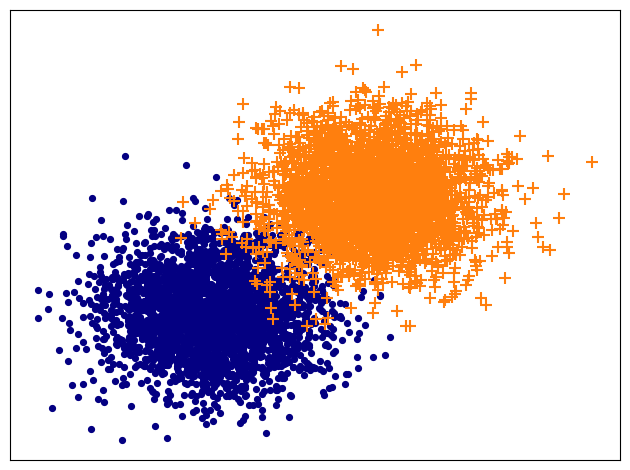

In [25]:
# Parameters
seed1 = 1
seed2 = 2
n0 = 3000
n1 = 3000

# Dataset 1
mu0 = [0, 0]
sigma0 = [[1, 0], [0, 1]]
mu1 = [3, 3]
sigma1 = [[1, 0], [0, 1]]

X, y = normal_generator2(mu0, sigma0, n0, mu1, sigma1, n1, seed1, seed2)

In [28]:
sigma = 5
delta = 0.5
seed = 0
k_min = 0
host_instance_by_layer_df, data_clusters, centroids_dict, results, k_auto = hostility_measure_Centroids(sigma, X, y, delta, k_min, seed=0)
k_auto

9

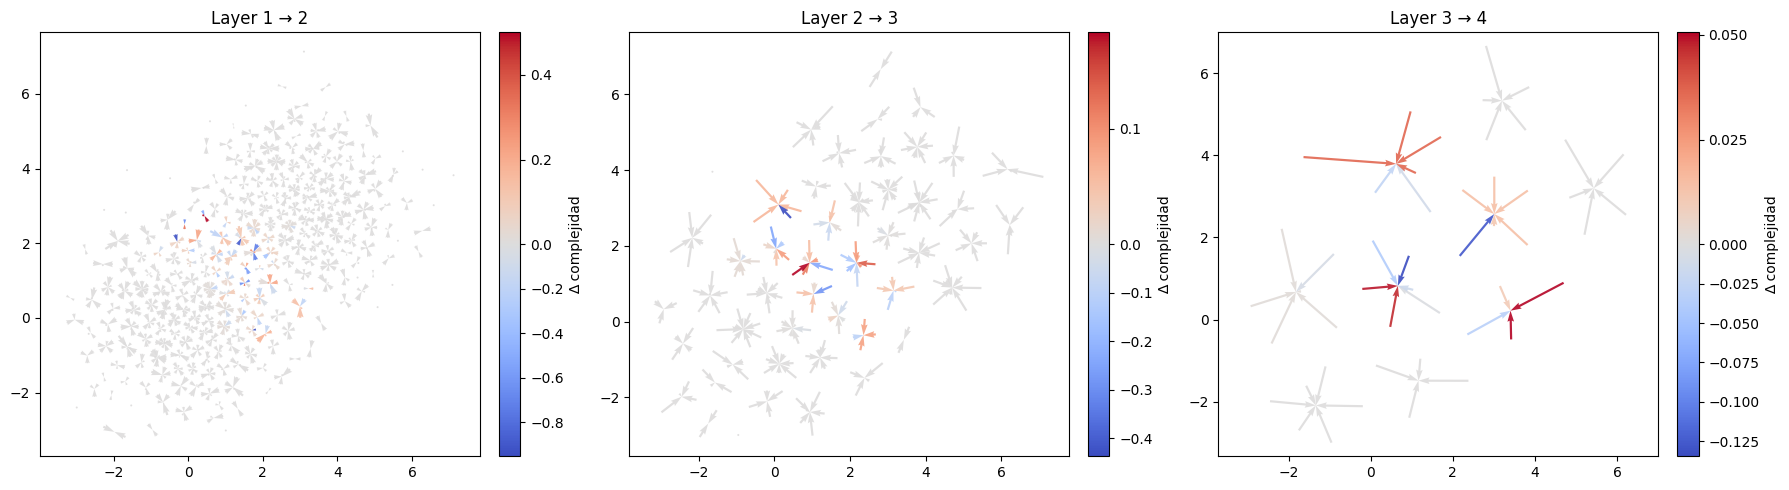

In [29]:
plot_hierarchical_quivers_with_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    k_auto=k_auto)

Observamos:
  * Primer gráfico. Movimientos muy pequeños (se pasa de puntos originales a primera tanda de centroides). Los únicos cambios de complejidad ocurren en puntos situados justo en el medio del gráfico. En el resto los cambios son aproximadamente 0.
  * Segundo gráfico. De nuevo, los únicos cambios ocurren en el centro de los datos. Se aprecia que alejarse de ese centro, disminuye la complejidad (flechas azules) y acercarse, aumenta la complejidad (flechas rojas).
  * Tercer gráfico. El patrón del segundo gráfico se vuelve a repetir pero ahora aun más claro.

Con esta visualización queda claro dónde está el lío y hacia donde es mejor moverse para minimizar la complejidad. Debería salir que ambas son importantes. HACER UN EJEMPLO EN 2D CON UNA SUPERFLUA PARA VISUALIZAR ILUSTRATIVAMENTE

Ahora la idea es ver si podemos cuantificar correctamente la magnitud de dichos movimientos con respecto a cada dimensión y con ello elaborar un ranking de utilidad de las variables que nos permita hacer feature selection. “direccionalidad por feature” → es como un gradiente de complejidad en el espacio de variables.


## Primera idea ranking feature selection

1. Descomponer el vector de movimiento. Para cada transición de centroide, vamos a mirar la contribución de cada feature (magnitud del cambio en esa dimensión) y vamos a asociar dicha contribución con el incremento de complejidad que haya ocurrido.
2. Calcular un score por feature. Una primera puede ser:
$$score(f_j) = \sum_{layers\ l_i} \Delta Complexity(l_i) \cdot \Delta Centroid_j(l_i)$$ donde $f_j$ indica la variable $j$, es decir, la dimensión $j$. El producto nos diría si movernos en esa dimensión está relacionado con aumentar o reducir complejidad.
3. Realizar un ranking con el score. Si el score es siempre positivo (la hostilidad aumenta), entonces esa variable "empeora" la complejidad, es decir, dificulta la capacidad de discernir entre las clases y deberíamos "eliminarla". Por el contrario, si es negativo, quiere decir que esa variable contribuye a simplificar la estructura de los datos y es una buena candidata.
